# Visualize SAM3 Segmentation Masks

This notebook visualizes the new segmentation masks from `data/processed/train_sam3` alongside the original images and ground truth labels.

In [1]:
import os
import sys
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import tifffile
import random

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

## Setup Paths

In [2]:
# Paths to data
IMAGES_DIR = Path("../data/processed/train_patches_256/AerialImageDataset/images")
GT_DIR = Path("../data/processed/train_patches_256/AerialImageDataset/gt")
SAM3_DIR = Path("../data/processed/train_sam3/train_sam3/AerialImageDataset")

print(f"Images directory exists: {IMAGES_DIR.exists()}")
print(f"Ground truth directory exists: {GT_DIR.exists()}")
print(f"SAM3 masks directory exists: {SAM3_DIR.exists()}")

Images directory exists: True
Ground truth directory exists: True
SAM3 masks directory exists: True


## Helper Functions

In [ ]:
def get_matching_files(sam3_mask_path, images_dir, gt_dir):
    """
    Given a SAM3 mask path, find the corresponding original image and ground truth.
    
    SAM3 mask: austin1_patch_006_x768_y0_processed.tiff
    Image: austin1_patch_006_x768_y0.png
    GT: austin1_patch_006_x768_y0.png
    """
    # Remove '_processed.tiff' and replace with '.png'
    base_name = sam3_mask_path.stem.replace('_processed', '') + '.png'
    
    image_path = images_dir / base_name
    gt_path = gt_dir / base_name
    
    return image_path, gt_path


def create_comparison_mask(gt, sam3_mask):
    """
    Create a merged visualization of ground truth and SAM3 predictions.
    """
    gt_binary = (np.array(gt) > 128).astype(np.uint8)
    
    if sam3_mask.ndim == 3 and sam3_mask.shape[-1] == 2:
        sam3_binary = (sam3_mask[:, :, 0] > 0).astype(np.uint8)
    else:
        sam3_binary = (sam3_mask > 0).astype(np.uint8)
    
    h, w = gt_binary.shape
    comparison = np.zeros((h, w, 3), dtype=np.uint8)
    
    both = (gt_binary == 1) & (sam3_binary == 1)
    comparison[both] = [255, 255, 0]  # Yellow
    
    gt_only = (gt_binary == 1) & (sam3_binary == 0)
    comparison[gt_only] = [0, 255, 0]  # Green
    
    sam3_only = (gt_binary == 0) & (sam3_binary == 1)
    comparison[sam3_only] = [255, 0, 0]  # Red
        
    return comparison


def visualize_comparison(image_path, gt_path, sam3_path, ax_row=None, figsize=(12, 6)):
    """
    Visualize original image alongside merged ground truth + SAM3 comparison.
    """
    image = Image.open(image_path)
    gt = Image.open(gt_path)
    sam3_mask = tifffile.imread(sam3_path)
    
    comparison = create_comparison_mask(gt, sam3_mask)
    
    if ax_row is None:
        fig, ax_row = plt.subplots(1, 2, figsize=figsize)
    
    ax_row[0].imshow(image)
    ax_row[0].set_title('Original Image', fontsize=10)
    ax_row[0].axis('off')
    ax_row[1].imshow(comparison)
    ax_row[1].set_title('GT vs SAM3 (Green=GT only, Red=SAM3 only, Yellow=Both)', fontsize=9)
    ax_row[1].axis('off')
    
    return ax_row

## Color Legend

The comparison visualization uses the following color scheme:
- **Yellow**: Both GT and SAM3 agree (True Positives)
- **Green**: Ground truth only - missed by SAM3 (False Negatives)
- **Red**: SAM3 prediction only - not in GT (False Positives)
- **Black**: Neither - background (True Negatives)

## Visualize Random Samples

In [ ]:
sam3_files = sorted(list(SAM3_DIR.glob('*_processed.tiff')))
print(f"Found {len(sam3_files)} SAM3 mask files")

num_samples = 8
random_samples = random.sample(sam3_files, min(num_samples, len(sam3_files)))

print(f"\nVisualizing {len(random_samples)} random samples...")

Found 13284 SAM3 mask files

Visualizing 8 random samples...


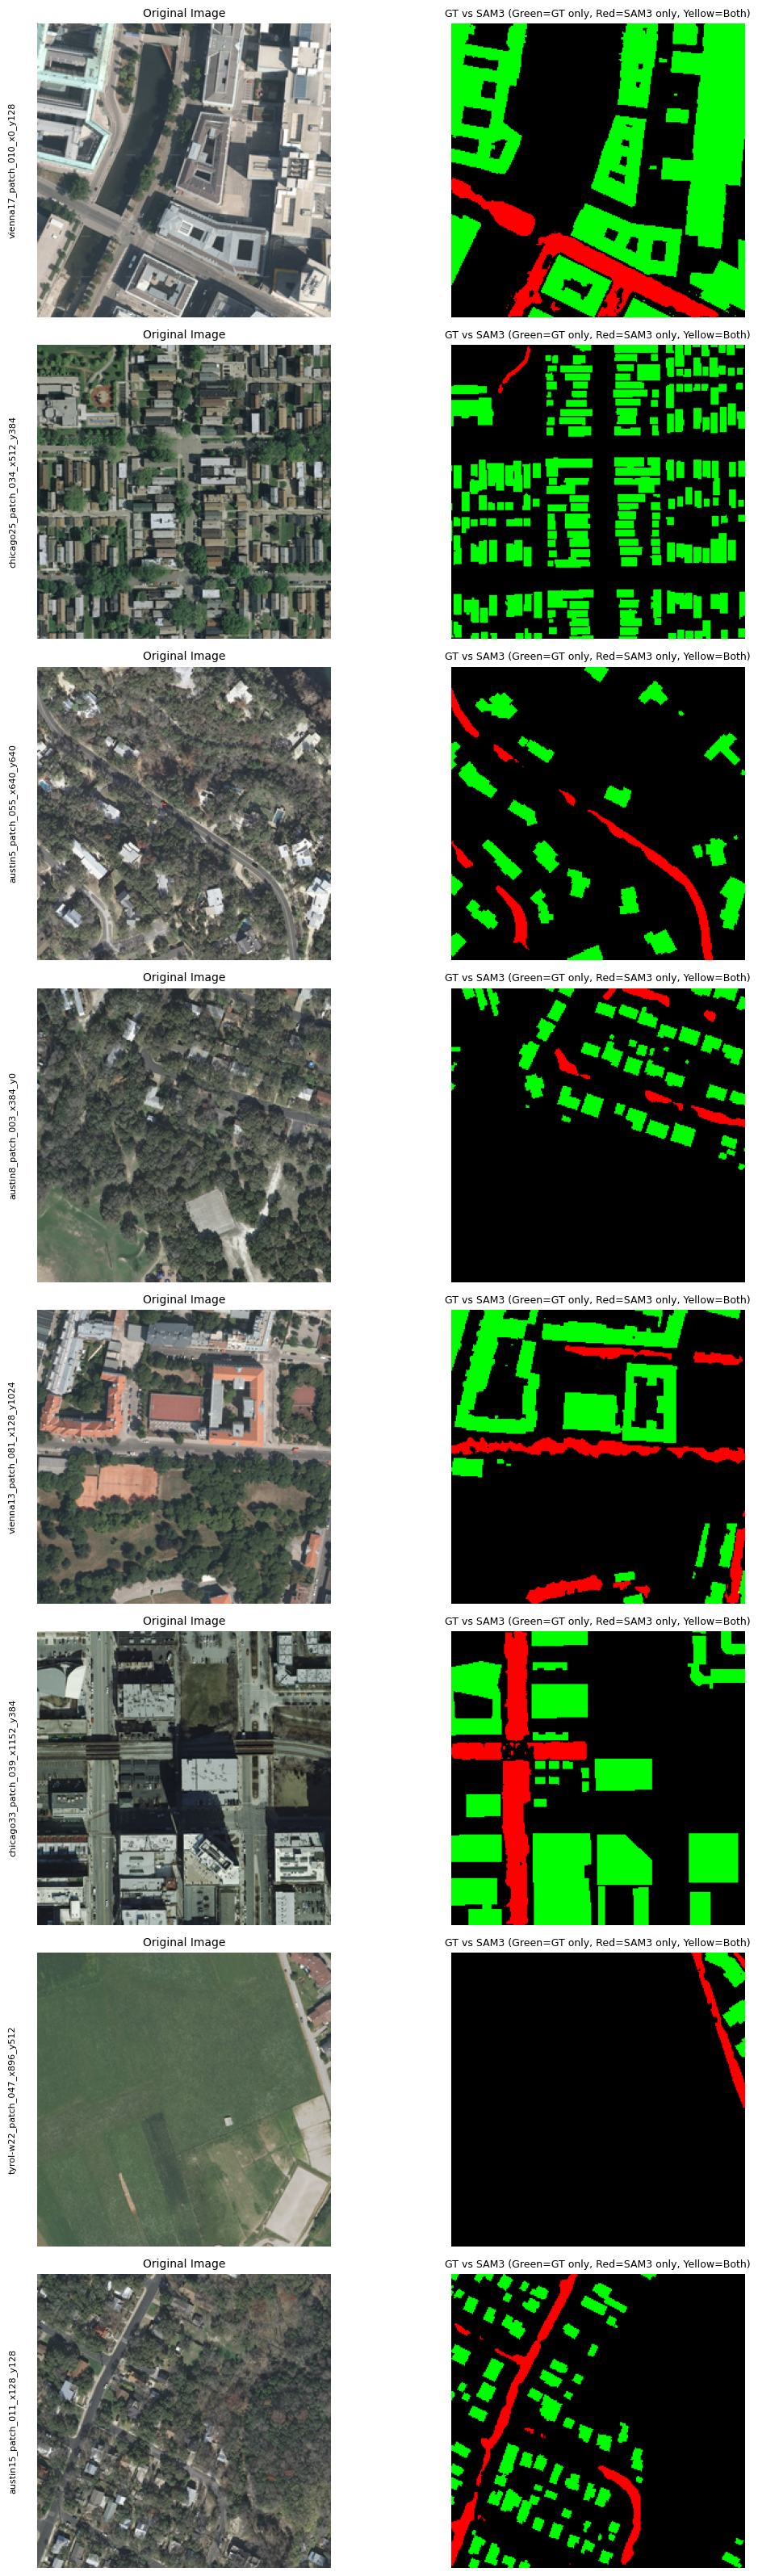

In [ ]:
fig, axes = plt.subplots(len(random_samples), 2, figsize=(12, 4 * len(random_samples)))

if len(random_samples) == 1:
    axes = axes.reshape(1, -1)

for idx, sam3_path in enumerate(random_samples):
    image_path, gt_path = get_matching_files(sam3_path, IMAGES_DIR, GT_DIR)
    
    if not image_path.exists() or not gt_path.exists():
        print(f"Warning: Missing files for {sam3_path.name}")
        continue
    
    visualize_comparison(image_path, gt_path, sam3_path, ax_row=axes[idx])
    
    axes[idx, 0].text(
        -0.1, 0.5, sam3_path.stem.replace('_processed', ''),
        transform=axes[idx, 0].transAxes,
        fontsize=8, rotation=90, verticalalignment='center'
    )

plt.tight_layout()
plt.show()

## Visualize Specific Samples

You can also visualize specific samples by name.

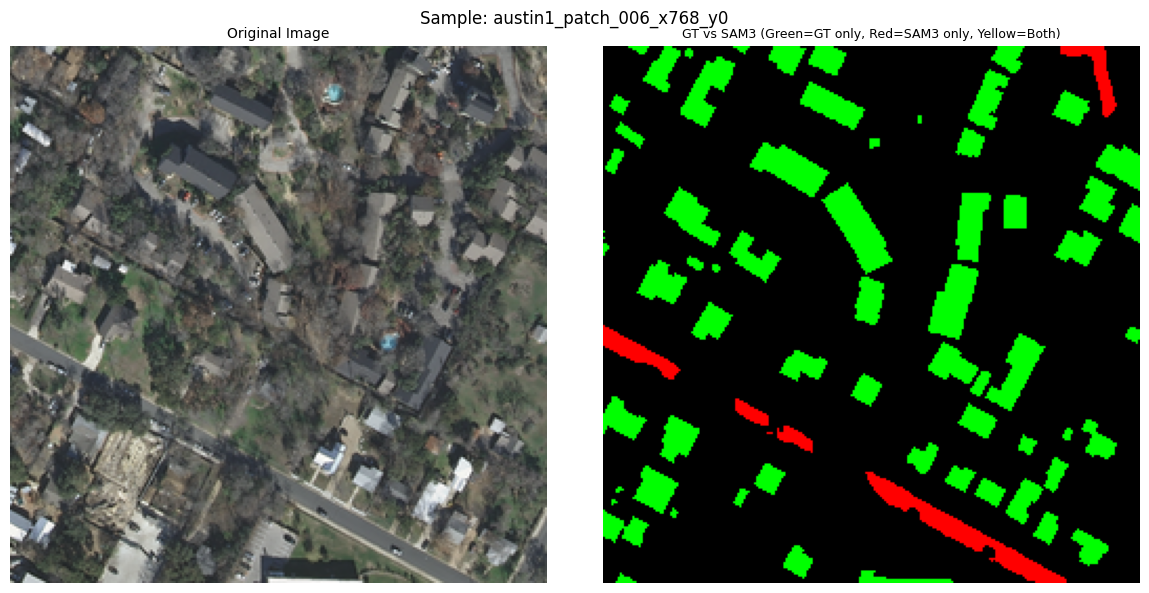

In [ ]:
sample_name = "austin1_patch_006_x768_y0_processed.tiff"
sam3_path = SAM3_DIR / sample_name

if sam3_path.exists():
    image_path, gt_path = get_matching_files(sam3_path, IMAGES_DIR, GT_DIR)
    
    if image_path.exists() and gt_path.exists():
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        visualize_comparison(image_path, gt_path, sam3_path, ax_row=axes)
        plt.suptitle(f"Sample: {sample_name.replace('_processed.tiff', '')}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Original image or ground truth not found for {sample_name}")
else:
    print(f"SAM3 mask not found: {sample_name}")

## Browse by City

Let's look at samples from different cities.

In [ ]:
cities = {}
for sam3_file in sam3_files:
    city = ''.join([c for c in sam3_file.stem.split('_')[0] if not c.isdigit()])
    if city not in cities:
        cities[city] = []
    cities[city].append(sam3_file)

print("Cities in dataset:")
for city, files in cities.items():
    print(f"  {city}: {len(files)} samples")

Cities in dataset:
  austin: 3072 samples
  chicago: 3077 samples
  kitsap: 2857 samples
  tyrol-w: 2485 samples
  vienna: 715 samples


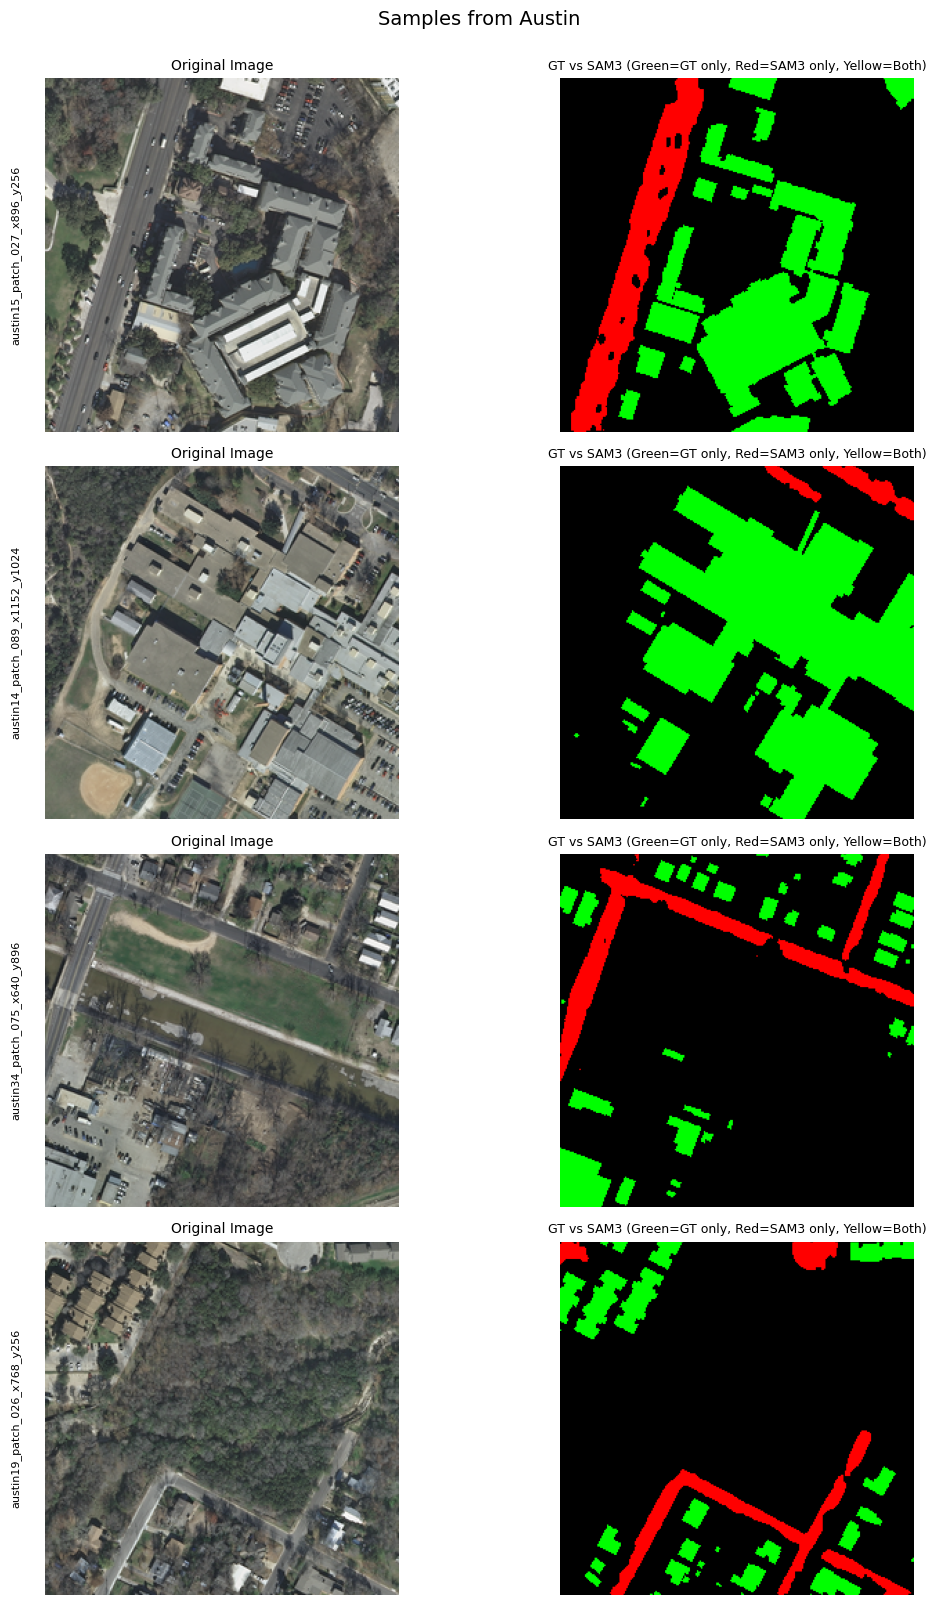

In [ ]:
city_to_visualize = 'austin'
num_samples_per_city = 4

if city_to_visualize in cities:
    city_samples = random.sample(cities[city_to_visualize], 
                                 min(num_samples_per_city, len(cities[city_to_visualize])))
    
    fig, axes = plt.subplots(len(city_samples), 2, figsize=(12, 4 * len(city_samples)))
    
    if len(city_samples) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sam3_path in enumerate(city_samples):
        image_path, gt_path = get_matching_files(sam3_path, IMAGES_DIR, GT_DIR)
        
        if image_path.exists() and gt_path.exists():
            visualize_comparison(image_path, gt_path, sam3_path, ax_row=axes[idx])
            axes[idx, 0].text(
                -0.1, 0.5, sam3_path.stem.replace('_processed', ''),
                transform=axes[idx, 0].transAxes,
                fontsize=8, rotation=90, verticalalignment='center'
            )
    
    plt.suptitle(f"Samples from {city_to_visualize.capitalize()}", fontsize=14, y=1.0)
    plt.tight_layout()
    plt.show()
else:
    print(f"City '{city_to_visualize}' not found in dataset")